# Diffusivity - General - Batch

This notebook processes the traj_50 data before 11192021.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import trackpy as tp
from skimage import io
from corrLib import readdata, xy_bin
from xiaolei.chain.tracking import gauss1
from scipy.optimize import curve_fit
from myImageLib import bestcolor, dirrec
from utils import *
import dufte
plt.style.use('default')
from scipy.signal import savgol_filter
from IPython.display import clear_output
from matplotlib import cm

## Sparce trajectory analysis

In [3]:
folder = r'C:\Users\liuzy\Documents\Data\DE\11032021\Analysis\01'
traj = pd.read_csv(os.path.join(folder, 'traj_50.csv'))
t = traj.assign(frame=traj.index, particle=0)
msd = tp.msd(t, mpp=0.33, fps=1, max_lagtime=100)

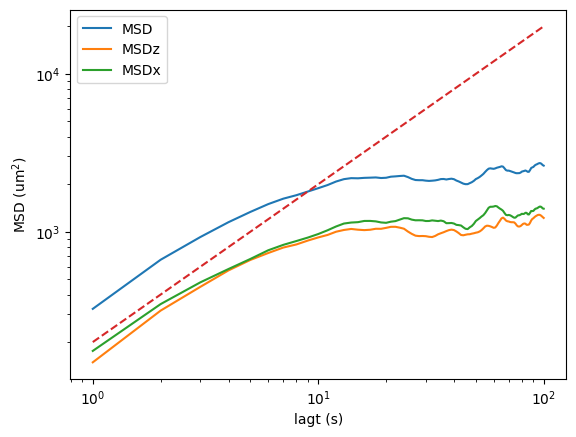

In [7]:
plt.plot(msd.lagt, msd.msd, label='MSD')
plt.plot(msd.lagt, msd['<x^2>'], label='MSDz')
plt.plot(msd.lagt, msd['<y^2>'], label='MSDx')
plt.loglog()
plt.plot(msd.lagt, 200*msd.lagt, ls='--')
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')
plt.legend()

**Comments:** the MSD obtained from 600 points look ok. 600 more can potentially complete the short time regime. 

In [74]:
traj = pd.read_csv(os.path.join(folder, 'traj_1.csv'))
t = traj.assign(frame=traj.index, particle=0)

In [34]:
msd = tp.msd(t, fps=50, mpp=0.33, max_lagtime=3000)

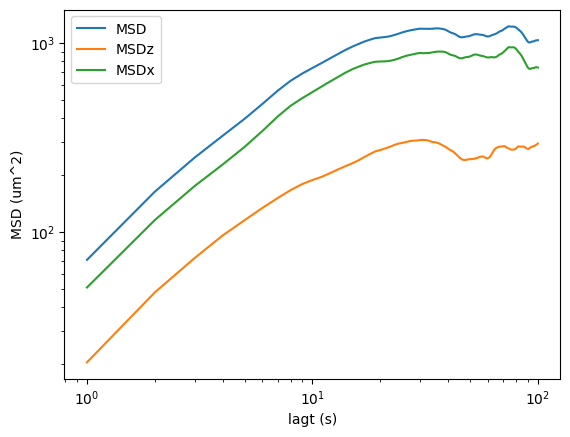

In [8]:
plt.plot(msd.lagt, msd.msd, label='MSD')
plt.plot(msd.lagt, msd['<x^2>'], label='MSDz')
plt.plot(msd.lagt, msd['<y^2>'], label='MSDx')
plt.loglog()
# plt.plot(msd.lagt, 200*msd.lagt, ls='--')
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um^2)')
plt.legend()
# plt.xlim([0, 1])

In [75]:
t['x'] = savgol_filter(t['x'], 5, 3)
t['y'] = savgol_filter(t['y'], 5, 3)

In [76]:
msd = tp.msd(t, fps=50, mpp=0.33, max_lagtime=3000)

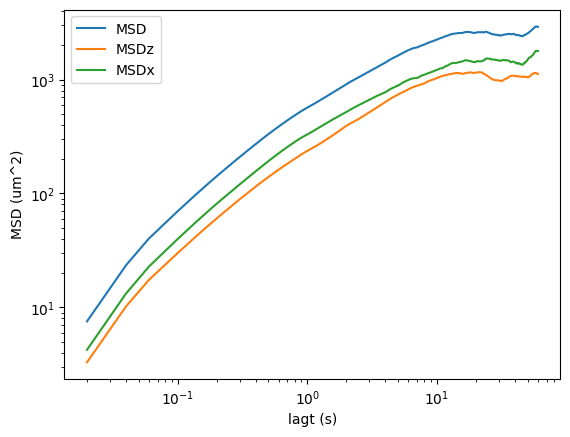

In [77]:
plt.plot(msd.lagt, msd.msd, label='MSD')
plt.plot(msd.lagt, msd['<x^2>'], label='MSDz')
plt.plot(msd.lagt, msd['<y^2>'], label='MSDx')
plt.loglog()
# plt.plot(msd.lagt, 200*msd.lagt, ls='--')
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um^2)')
plt.legend()
# plt.xlim([0, 1])

In [70]:
# tracking quality
image_folder = r'C:\Users\liuzy\Documents\Data\DE\11032021\01'
l = readdata(image_folder, 'tif')
save_folder = os.path.join(folder, 'tracking_quality')
if os.path.exists(save_folder) == False:
    os.makedirs(save_folder)
for num, i in l[25::50].iterrows():
    img = io.imread(i.Dir)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.imshow(img, cmap='gray')
    ax.scatter(t.x[num], t.y[num])
#     plt.pause(.5)
    clear_output(wait=True)
    fig.savefig(os.path.join(save_folder, i.Name+'.jpg'), dpi=50)
    plt.close()    

## traj -> MSD

In [26]:
def traj_to_msd(traj_dir, fps=50, mpp=0.33):
    """Read traj file and calculate MSD, save MSD to file in the same folder as traj file.
    Name the MSD file by replacing "traj" in traj file name with "MSD". 
    For example, the MSD file for traj file "traj_50_11022021_01.csv" will be renamed to "MSD_50_11022021_01.csv".
    Args:
    traj_dir -- directory of traj file (.csv containing x, y, frame, particle
    fps -- frames per second, this value is usually in log file
    mpp -- microns per pixel, this value is usually in log file
    Returns:
    msd"""
    traj = pd.read_csv(traj_dir)
    if "particle" not in traj:
        traj = traj.assign(particle=0)
    if "frame" not in traj:
        traj = traj.assign(frame=traj.index)
    msd = tp.msd(traj, fps=fps, mpp=mpp, max_lagtime=int(len(traj)/10))
    msd.to_csv(traj_dir.replace("traj", "MSD"), index=False)
    return msd

In [25]:
test_dir = "~/Documents/GitHub/DE/Data/Real_data/traj_50_10272021_03.csv"
msd = traj_to_msd(test_dir)

In [43]:
# load log 
data_folder = r"C:\Users\liuzy\Documents\Github\DE\Data\Real_data"
log = pd.read_csv(os.path.join(data_folder, "OD50-75.csv"))
log = log.assign(d_diff=log.D-log.d, d_ratio=log.D/log.d)
log.head()

,Unnamed: 0,#,OD,D,d,MMP,FPS,Easy to analyze?,Plane,Comment,date,Quality,d_diff,d_ratio
0,3,3,70.0,127.5,12.3,0.33,50.0,No,XZ,NaN,10272021,NaN,115.2,10.365854
1,11,11,65.0,48.9,17.0,0.11,50.0,Yes,XZ,NaN,10262021,NaN,31.9,2.876471
2,12,12,65.0,74.0,15.4,0.11,50.0,Yes,XZ,small inner drop,10262021,NaN,58.6,4.805195
3,13,13,65.0,63.4,30.9,0.11,50.0,Yes,XZ,large inner drop,10262021,NaN,32.5,2.051780
4,15,15,70.0,100.0,25.7,0.11,50.0,Yes,XZ,outer size increasing,10262021,NaN,74.3,3.891051


In [35]:
log

,Unnamed: 0,#,OD,D,d,MMP,FPS,Easy to analyze?,Plane,Comment,date,Quality
0,3,3,70.0,127.5,12.3,0.33,50.0,No,XZ,NaN,10272021,NaN
1,12,12,65.0,74.0,15.4,0.11,50.0,Yes,XZ,small inner drop,10262021,NaN
2,4,4,66.0,132.6,15.6,0.33,50.0,No,XZ,NaN,11032021,NaN
3,11,11,65.0,48.9,17.0,0.11,50.0,Yes,XZ,NaN,10262021,NaN
4,16,16,70.0,120.7,18.9,0.11,50.0,No,XZ,"outer size increasing, too many drops in a sam...",10262021,NaN
5,6,6,66.0,195.1,19.2,0.33,50.0,No,XZ,NaN,11032021,NaN
6,5,5,51.0,140.0,20.0,0.33,50.0,NaN,XZ,"very large outer drop 140/20, have to use 20x ...",11022021,NaN
7,9,9,57.0,159.1,20.2,0.33,50.0,No,XZ,Inner droplet pops out,11032021,NaN
8,8,8,57.0,72.5,21.1,0.33,50.0,Yes,XZ,Inner droplet pops out,11032021,NaN
9,21,21,65.0,197.3,24.7,0.33,50.0,No,XZ,"small inner, last video of the day..",11022021,NaN


In [27]:
# calculate MSD and save to file
for num, i in log.iterrows():
    date_str = "{:08d}".format(int(i.date))
    num_str = "{:02d}".format(int(i["#"]))
    traj_dir = os.path.join(data_folder, "traj_50_{}_{}.csv".format(date_str, num_str))
    video_FPS = i.FPS
    interval = 50
    fps = interval / i.FPS
    msd = traj_to_msd(traj_dir, fps=fps, mpp=i.MMP)

### Plot MSD with different color and marker scheme

##### Outer diameter D

Text(0, 0.5, 'MSD (um$^2$)')

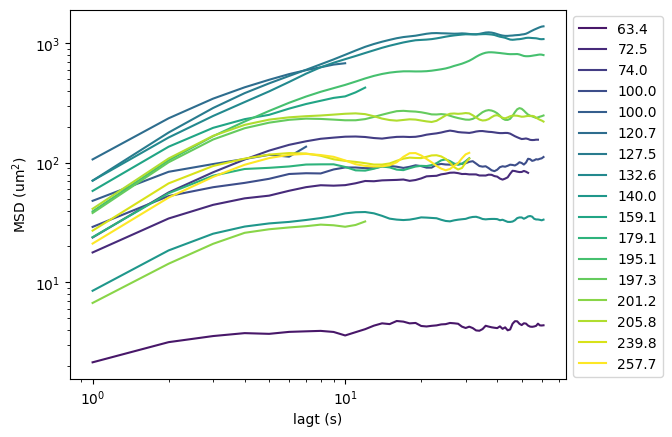

In [31]:
# read MSD from files and plot
log.sort_values("D", inplace=True)
log.reset_index(drop=True, inplace=True)
viridis = cm.get_cmap('viridis', len(log))
for num, i in log[1:].iterrows():
    date_str = "{:08d}".format(int(i.date))
    num_str = "{:02d}".format(int(i["#"]))
    msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
    msd = pd.read_csv(msd_dir)
    plt.plot(msd.lagt, msd.msd, color=viridis(num), label=i.D)
plt.loglog()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

Text(0, 0.5, 'MSD (um$^2$)')

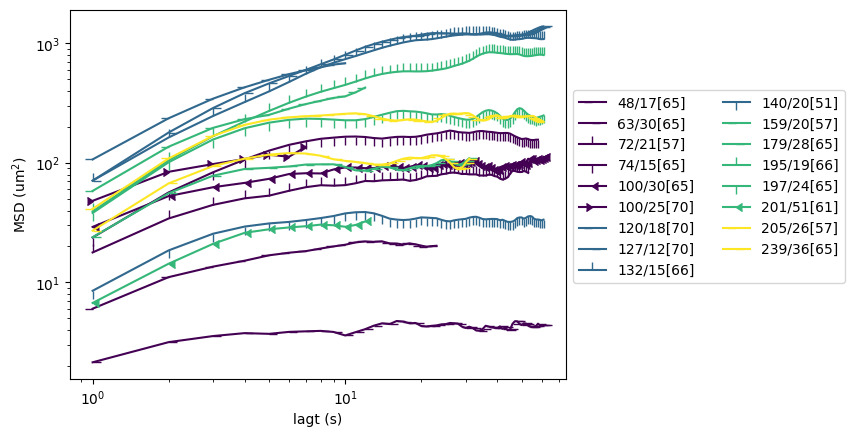

In [32]:
# plot by grouping the curves by outer diameter D
plt.figure(dpi=100)
log.sort_values("D", inplace=True)
D_bins = np.linspace(log.D.min(), log.D.max(), 5).astype('int')
viridis = cm.get_cmap('viridis', len(D_bins)-1)
for cnum, j in enumerate(range(len(D_bins)-1)):
    sublog = log.loc[(log.D>=D_bins[j])&(log.D<D_bins[j+1])]
    mnum = 0
    for num, i in sublog.iterrows():
        date_str = "{:08d}".format(int(i.date))
        num_str = "{:02d}".format(int(i["#"]))
        msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
        msd = pd.read_csv(msd_dir)
        plt.plot(msd.lagt, msd.msd, color=viridis(cnum), label="{0:d}/{1:d}[{2:d}]".format(int(i.D),int(i.d),int(i.OD)), marker=mnum)
        mnum += 1
plt.loglog()
plt.legend(bbox_to_anchor=(1, 0.8), ncol=2)
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

##### Inner diameter d

Text(0, 0.5, 'MSD (um$^2$)')

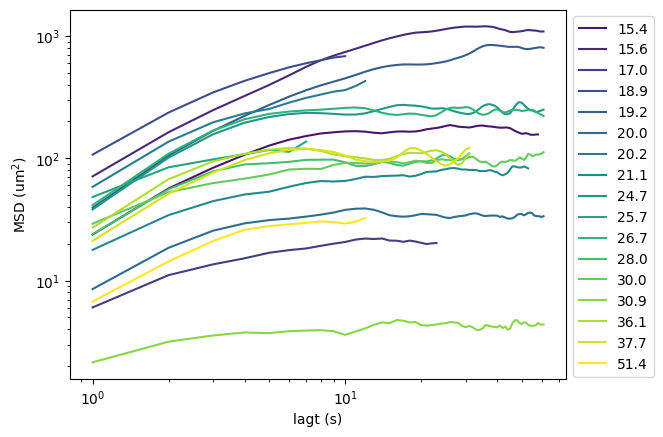

In [33]:
# read MSD from files and plot
log.sort_values("d", inplace=True)
log.reset_index(drop=True, inplace=True)
viridis = cm.get_cmap('viridis', len(log))
for num, i in log[1:].iterrows():
    date_str = "{:08d}".format(int(i.date))
    num_str = "{:02d}".format(int(i["#"]))
    msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
    msd = pd.read_csv(msd_dir)
    plt.plot(msd.lagt, msd.msd, color=viridis(num), label=i.d)
plt.loglog()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

Text(0, 0.5, 'MSD (um$^2$)')

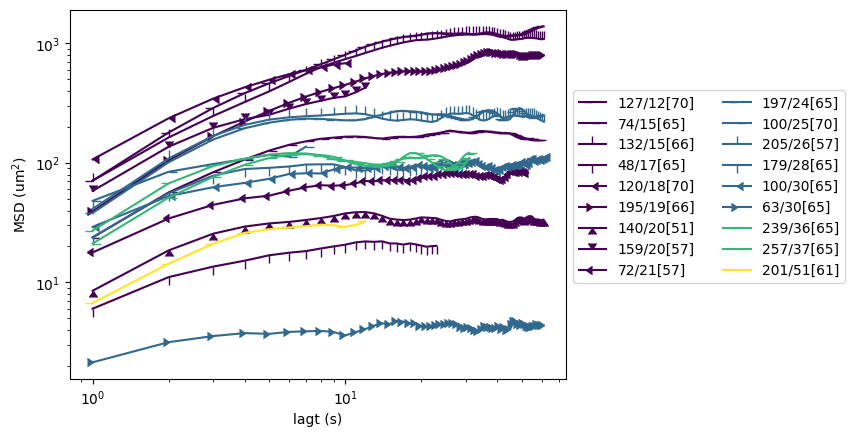

In [51]:
# plot by grouping the curves by outer diameter D
plt.figure(dpi=100)
log.sort_values("d", inplace=True)
d_bins = np.linspace(log.d.min(), log.d.max()+1, 5).astype('int')
viridis = cm.get_cmap('viridis', len(d_bins)-1)
for cnum, j in enumerate(range(len(d_bins)-1)):
    sublog = log.loc[(log.d>=d_bins[j])&(log.d<d_bins[j+1])]
    mnum = 0
    for num, i in sublog.iterrows():
        date_str = "{:08d}".format(int(i.date))
        num_str = "{:02d}".format(int(i["#"]))
        msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
        msd = pd.read_csv(msd_dir)
        plt.plot(msd.lagt, msd.msd, color=viridis(cnum), 
                 label="{0:d}/{1:d}[{2:d}]".format(int(i.D),int(i.d),int(i.OD),i), marker=mnum)
        mnum += 1
plt.loglog()
plt.legend(bbox_to_anchor=(1, 0.8), ncol=2)
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

In [41]:
log

,Unnamed: 0,#,OD,D,d,MMP,FPS,Easy to analyze?,Plane,Comment,date,Quality
0,3,3,70.0,127.5,12.3,0.33,50.0,No,XZ,NaN,10272021,NaN
1,12,12,65.0,74.0,15.4,0.11,50.0,Yes,XZ,small inner drop,10262021,NaN
2,4,4,66.0,132.6,15.6,0.33,50.0,No,XZ,NaN,11032021,NaN
3,11,11,65.0,48.9,17.0,0.11,50.0,Yes,XZ,NaN,10262021,NaN
4,16,16,70.0,120.7,18.9,0.11,50.0,No,XZ,"outer size increasing, too many drops in a sam...",10262021,NaN
5,6,6,66.0,195.1,19.2,0.33,50.0,No,XZ,NaN,11032021,NaN
6,5,5,51.0,140.0,20.0,0.33,50.0,NaN,XZ,"very large outer drop 140/20, have to use 20x ...",11022021,NaN
7,9,9,57.0,159.1,20.2,0.33,50.0,No,XZ,Inner droplet pops out,11032021,NaN
8,8,8,57.0,72.5,21.1,0.33,50.0,Yes,XZ,Inner droplet pops out,11032021,NaN
9,21,21,65.0,197.3,24.7,0.33,50.0,No,XZ,"small inner, last video of the day..",11022021,NaN


##### D - d, the difference

Text(0, 0.5, 'MSD (um$^2$)')

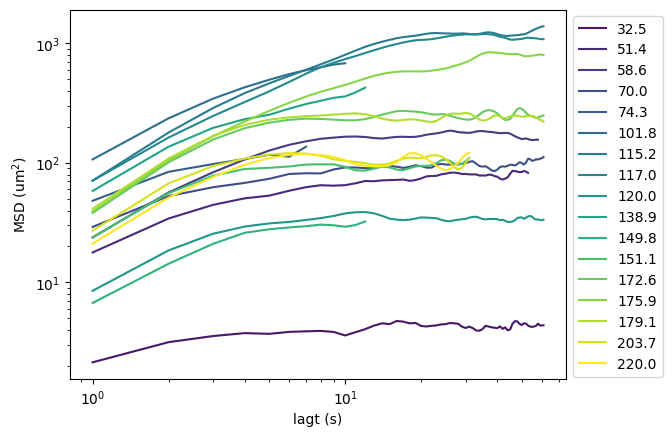

In [45]:
# read MSD from files and plot
item = "d_diff"
log.sort_values(item, inplace=True)
log.reset_index(drop=True, inplace=True)
viridis = cm.get_cmap('viridis', len(log))
for num, i in log[1:].iterrows():
    date_str = "{:08d}".format(int(i.date))
    num_str = "{:02d}".format(int(i["#"]))
    msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
    msd = pd.read_csv(msd_dir)
    plt.plot(msd.lagt, msd.msd, color=viridis(num), label="{:.1f}".format(i.d_diff))
plt.loglog()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

Text(0, 0.5, 'MSD (um$^2$)')

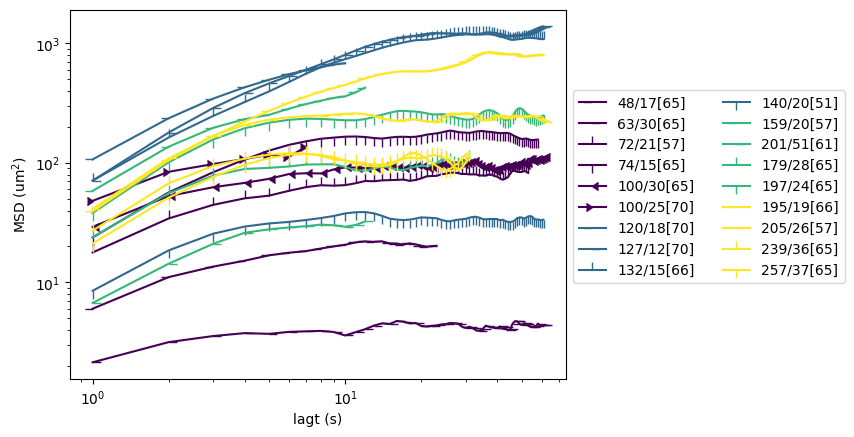

In [50]:
# plot by grouping the curves by outer diameter D
item = "d_diff"
plt.figure(dpi=100)
log.sort_values(item, inplace=True)
d_bins = np.linspace(log[item].min(), log[item].max()+1, 5).astype('int')
viridis = cm.get_cmap('viridis', len(d_bins)-1)
for cnum, j in enumerate(range(len(d_bins)-1)):
    sublog = log.loc[(log[item]>=d_bins[j])&(log[item]<d_bins[j+1])]
    mnum = 0
    for num, i in sublog.iterrows():
        date_str = "{:08d}".format(int(i.date))
        num_str = "{:02d}".format(int(i["#"]))
        msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
        msd = pd.read_csv(msd_dir)
        plt.plot(msd.lagt, msd.msd, color=viridis(cnum), 
                 label="{0:d}/{1:d}[{2:d}]".format(int(i.D),int(i.d),int(i.OD)), marker=mnum)
        mnum += 1
plt.loglog()
plt.legend(bbox_to_anchor=(1, 0.8), ncol=2)
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

##### D / d, the ratio

Text(0, 0.5, 'MSD (um$^2$)')

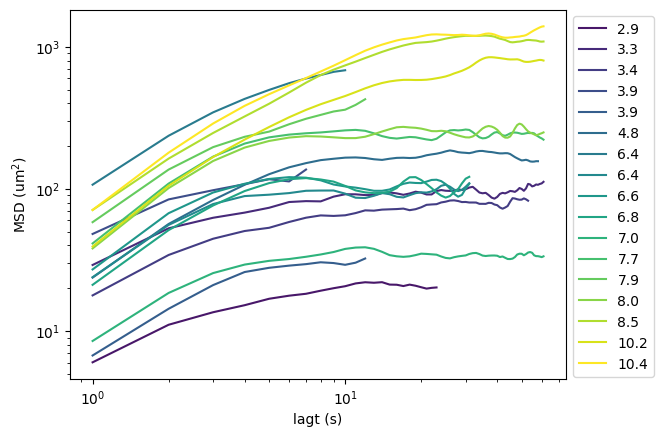

In [47]:
# read MSD from files and plot
item = "d_ratio"
log.sort_values(item, inplace=True)
log.reset_index(drop=True, inplace=True)
viridis = cm.get_cmap('viridis', len(log))
for num, i in log[1:].iterrows():
    date_str = "{:08d}".format(int(i.date))
    num_str = "{:02d}".format(int(i["#"]))
    msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
    msd = pd.read_csv(msd_dir)
    plt.plot(msd.lagt, msd.msd, color=viridis(num), label="{:.1f}".format(i.d_ratio))
plt.loglog()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

Text(0, 0.5, 'MSD (um$^2$)')

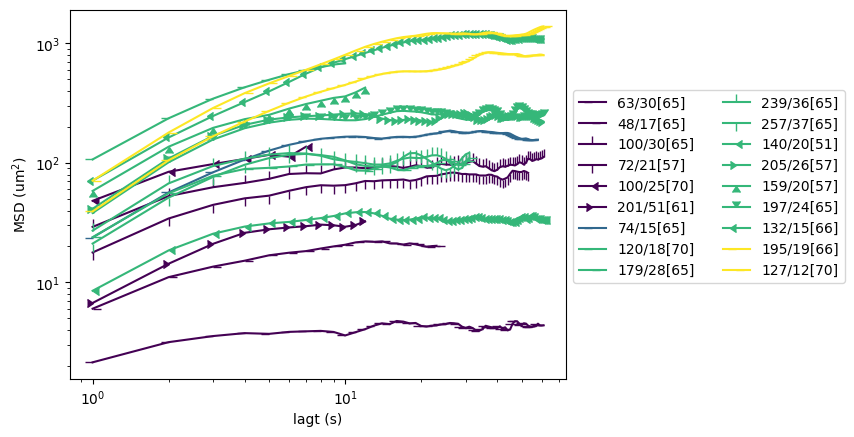

In [49]:
# plot by grouping the curves by outer diameter D
item = "d_ratio"
plt.figure(dpi=100)
log.sort_values(item, inplace=True)
d_bins = np.linspace(log[item].min(), log[item].max()+1, 5).astype('int')
viridis = cm.get_cmap('viridis', len(d_bins)-1)
for cnum, j in enumerate(range(len(d_bins)-1)):
    sublog = log.loc[(log[item]>=d_bins[j])&(log[item]<d_bins[j+1])]
    mnum = 0
    for num, i in sublog.iterrows():
        date_str = "{:08d}".format(int(i.date))
        num_str = "{:02d}".format(int(i["#"]))
        msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
        msd = pd.read_csv(msd_dir)
        plt.plot(msd.lagt, msd.msd, color=viridis(cnum), 
                 label="{0:d}/{1:d}[{2:d}]".format(int(i.D),int(i.d),int(i.OD)), marker=mnum)
        mnum += 1
plt.loglog()
plt.legend(bbox_to_anchor=(1, 0.8), ncol=2)
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

C:\Users\liuzy\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Text(0, 0.5, 'MSD (um$^2$)')

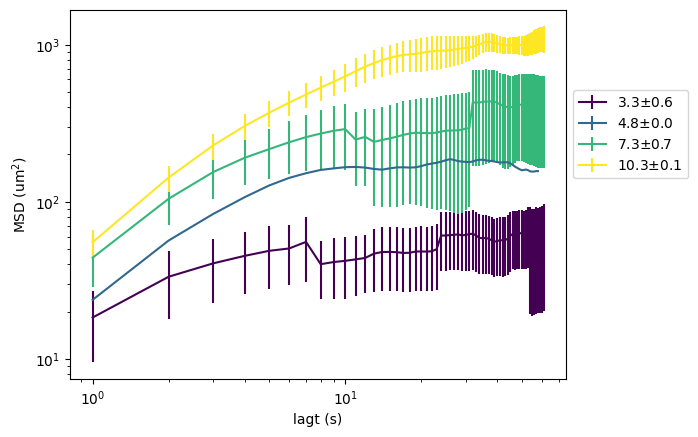

In [77]:
# average the D/d regrouping
item = "d_ratio"
plt.figure(dpi=100)
log.sort_values(item, inplace=True)
d_bins = np.linspace(log[item].min(), log[item].max()+1, 5).astype('int')
viridis = cm.get_cmap('viridis', len(d_bins)-1)
for cnum, j in enumerate(range(len(d_bins)-1)):
    sublog = log.loc[(log[item]>=d_bins[j])&(log[item]<d_bins[j+1])]
    mnum = 0
    msd_list = []
    d_ratio_list = []
    for num, i in sublog.iterrows():
        date_str = "{:08d}".format(int(i.date))
        num_str = "{:02d}".format(int(i["#"]))
        msd_dir = os.path.join(data_folder, "MSD_50_{}_{}.csv".format(date_str, num_str))
        msd = pd.read_csv(msd_dir)[['msd', 'lagt']].set_index('lagt')
        msd_list.append(msd)
    msd_concat = pd.concat(msd_list, axis=1)
    msd_avg = msd_concat.mean(axis=1)
    msd_std = msd_concat.std(axis=1)
    plt.errorbar(msd_concat.index, msd_avg, yerr=msd_std/2, color=viridis(cnum), 
            label="{0:.1f}$\pm${1:.1f}".format(sublog['d_ratio'].mean(), sublog['d_ratio'].std(ddof=0)))
plt.loglog()
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('lagt (s)')
plt.ylabel('MSD (um$^2$)')

In [65]:
msd_avg

lagt
1.0       55.230539
2.0      142.567116
3.0      228.000180
4.0      303.208329
5.0      368.193420
           ...     
57.0    1062.837317
58.0    1076.340178
59.0    1088.349565
60.0    1095.717150
61.0    1096.034464
Length: 61, dtype: float64

In [63]:
sublog['d_ratio'].std()

nan